<a href="https://colab.research.google.com/github/LilDataScientist/Covid-Lung-CT-Image-Segmentation/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
!pip install livelossplot

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-v4wm7yvr
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-v4wm7yvr


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import dependencies

In [4]:
import torchvision
import random
import torch
import json
import csv
import os

import segmentation_models_pytorch as smp
import torch.nn.functional as F
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data.sampler import SubsetRandomSampler
from livelossplot import PlotLosses
from livelossplot.outputs import BokehPlot
from tqdm.notebook import tqdm
from PIL import Image
from torch import nn

In [5]:
PROJECT_PATH = '/content/drive/MyDrive/Covid Lung CT Image Segmentation'

device = torch.device('cuda:0')

# Dataset class

Since each observation consists of many (30-50) layers we are goind to parse it as a single image.  
So insted of having (n, k, 512, 512) we will have (n * k, 512, 512)

In [6]:
def AugmentFlip(X, y):
    return torchvision.transforms.functional.vflip(X), torchvision.transforms.functional.vflip(y)

def AugmentRotate(X, y):
    degs = [-20, 20, -15, 15, -10, 10, -5, 5]
    deg = random.choice(degs)
    return torchvision.transforms.functional.rotate(X, deg), torchvision.transforms.functional.rotate(y, deg)

In [7]:
class CovidDataset(Dataset):
    def __init__(self, path_to_data, path_to_json, max_no_covid=1000000, augumentations=0):
        self.path_to_data = path_to_data
        self.path_to_json = path_to_json
        self.max_no_covid = max_no_covid
        self.augumentations = augumentations
        
        path_images = os.path.join(path_to_data, 'images')
        path_labels = os.path.join(path_to_data, 'labels')
        
        with open(path_to_json, 'r') as f:
            dict_training = json.load(f)
            
        self.x = torch.Tensor()
        self.y = torch.Tensor()

        count_with_covid_in_dataset = 0
        count_without_covid_in_dataset = 0
        
        for entry in tqdm(dict_training):
            images = nib.load(os.path.join(path_images, entry['image'][:-3])).get_fdata()
            labels = nib.load(os.path.join(path_labels, entry['label'][:-3])).get_fdata()
            
            images = torch.tensor(images.swapaxes(0, 2).swapaxes(1, 2).reshape(-1, 1, 512, 512))
            labels = torch.tensor(labels.swapaxes(0, 2).swapaxes(1, 2).reshape(-1, 1, 512, 512))

            for image, label in zip(images, labels):
                covid_area = label.sum()

                if covid_area == 0:
                    if count_without_covid_in_dataset >= self.max_no_covid:
                        continue
                    else:
                        count_without_covid_in_dataset += 1
                    

                image, label = image.unsqueeze(0), label.unsqueeze(0)

                if self.x.numel() == 0:
                    self.x = image
                    self.y = label
                else:
                    self.x = torch.cat((self.x, image), dim=0)
                    self.y = torch.cat((self.y, label), dim=0)

                if random.random() > (1 - self.augumentations):
                    image, label = AugmentFlip(image, label)
                    self.x = torch.cat((self.x, image), dim=0)
                    self.y = torch.cat((self.y, label), dim=0)

                if random.random() > (1 - self.augumentations):
                    image, label = AugmentRotate(image, label)
                    self.x = torch.cat((self.x, image), dim=0)
                    self.y = torch.cat((self.y, label), dim=0)
                
        self.x = self.x.float()
        self.y = self.y.float()
        
    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

# Load training dataset

In [8]:
dataset = CovidDataset(path_to_data=f'{PROJECT_PATH}/data', 
                       path_to_json=f'{PROJECT_PATH}/training_data.json',
                       max_no_covid=50, augumentations=0.3)

  0%|          | 0/40 [00:00<?, ?it/s]

In [9]:
samples = dataset.x.shape[0] #1651

val_samples = samples // 100 * 20
test_samples = samples // 100 * 10
training_samples = samples - val_samples - test_samples

print(f'{samples} samples. {training_samples} Training samples. {val_samples} Validations samples. {test_samples} Test samples.')

1088 samples. 788 Training samples. 200 Validations samples. 100 Test samples.


In [10]:
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [training_samples, val_samples, test_samples])

train_loader = DataLoader(train_set, shuffle=True, batch_size=16)
val_loader   = DataLoader(val_set, shuffle=True, batch_size=16)
test_loader  = DataLoader(test_set, shuffle=True, batch_size=16)

# Visualize

In [11]:
def blend(image, mask):
    image = image.detach().cpu().numpy()
    mask = mask.detach().cpu().numpy()
    
    image = image.astype(np.float32)
    min_in = image.min()
    max_in = image.max()
    image = (image - min_in) / (max_in - min_in + 1e-8) * 255
    image = np.dstack((image, image, image)).astype(np.uint8)
    zeros = np.zeros_like(mask)
    mask = np.dstack((zeros, zeros, mask * 255)).astype(np.uint8)
    return Image.blend(
        Image.fromarray(image),
        Image.fromarray(mask),
        alpha=.2
    )

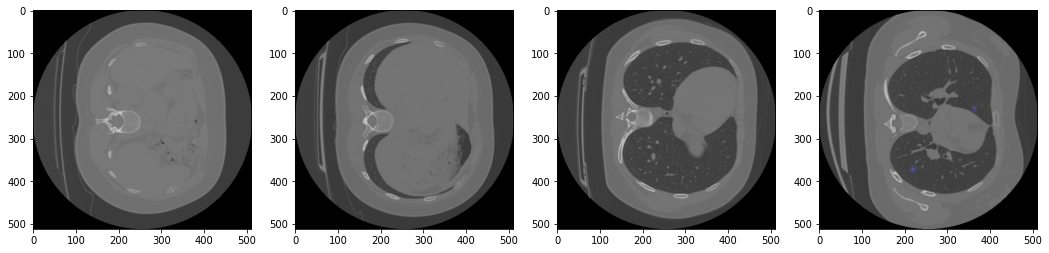

In [12]:
samples = [0, 10, 20, 30]

slices = [blend(dataset.x[sample, 0], dataset.y[sample, 0]) for sample in samples]
    
figure = plt.figure(figsize=(18, 18))
for i, image in enumerate(slices):
    ax = figure.add_subplot(1, len(slices), i + 1)
    ax.imshow(slices[i])

In [13]:
class TverskyLoss(nn.Module):
    def __init__(self, alpha=0.7):
        super(TverskyLoss, self).__init__()
        self.alpha = alpha

    def forward(self, inputs, targets, smooth=1):
        y_pred = inputs
        y_true = targets
        y_true_pos = y_true.view(-1)
        y_pred_pos = y_pred.view(-1)
        true_pos = torch.sum(y_true_pos * y_pred_pos)
        false_neg = torch.sum(y_true_pos * (1 - y_pred_pos))
        false_pos = torch.sum((1 - y_true_pos) * y_pred_pos)
        return 1 - (true_pos + smooth) / (true_pos + self.alpha * false_neg + (1 - self.alpha) * false_pos + smooth)

In [14]:
from collections import defaultdict

class Metrics:
    def __init__(self, model, train_loader, val_loader,
                 criterions={
                     'DiceLoss': TverskyLoss(alpha=0.5),
                     'TverskyLoss Alpha: 0.7': TverskyLoss(alpha=0.7)
                     },
                 loss={'name': 'DiceLoss', 'phase': 'val'}):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterions = criterions
        self.loss = loss
        self.best_records = defaultdict(lambda : 0)
        self.records = defaultdict(lambda : 0)

    def save(self):
        best_train_results = self.best_records[f"train_{self.loss['name']}"]
        best_val_results = self.best_records[f"val_{self.loss['name']}"]
        model_save_name = f"{self.model['name']}__train_{self.loss['name']}:{best_train_results}__val_{self.loss['name']}:{best_val_results}.pt"
        path = f"{PROJECT_PATH}/Models/{model_save_name}" 
        torch.save(self.model['model'].state_dict(), path)

    def forward(self):
        records = defaultdict(lambda: [])

        with torch.no_grad():
            for phase, loader in zip(['train', 'val'], [train_loader, val_loader]):
                for x, y in loader:
                    x, y = x.to(device), y.to(device)
                    output = self.model['model'](x)

                    for name, criterion in self.criterions.items():
                        records[f'{phase}_{name}'].append(criterion(output, y).item())

                    del x, y

                for name, criterion in self.criterions.items():
                    mean_criterion_loss = round(sum(records[f'{phase}_{name}']) / len(records[f'{phase}_{name}']), 4)

                    if (self.best_records[f'{phase}_{name}'] == 0) or (mean_criterion_loss < self.best_records[f'{phase}_{name}']):
                        self.best_records[f'{phase}_{name}'] = mean_criterion_loss

                        if (name == self.loss['name']) and (phase == self.loss['phase']):
                            self.save()

                    self.records[f'{phase}_{name}'] = mean_criterion_loss
                    
                    torch.cuda.empty_cache()

        return records

In [15]:
class BaseModel:
    def __init__(self, 
                 model,
                 train_loader,
                 val_loader,
                 test_loader,
                 optimizer,
                 metrics,
                 scheduler,
                 criterion):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.optimizer = optimizer 
        self.criterion = criterion
        self.scheduler = scheduler
        self.metrics = metrics

        self.epochs = 10
        self.eval_every = 1

        self.metrics = metrics


    def fit(self):
        %matplotlib inline
        plotlosses = PlotLosses(outputs=[BokehPlot()])

        for epoch in tqdm(range(self.epochs)):
            self.model.train()
            for x, y in self.train_loader:
                x, y = x.to(device), y.to(device)
                self.optimizer.zero_grad()
                output = self.model(x)
                loss = self.criterion(output, y)
                loss.backward()
                self.optimizer.step()
                del output, loss, x, y
                torch.cuda.empty_cache()
                
            if (epoch + 1) % self.eval_every == 0:
                self.model.eval()
                records = self.metrics.forward()

                for phase in ['train', 'val']:
                    for name in self.metrics.criterions.keys():
                        prefix = '' if phase == 'train' else f'{phase}_'
                        plotlosses.update({prefix+name: self.metrics.records[phase+'_'+name]},
                                        current_step=epoch + 1)
                plotlosses.send()

                
            self.scheduler.step(self.metrics.records[f"train_{self.metrics.loss['name']}"])

    def load_model(self, model_name):
        self.model.load_state_dict(torch.load(f'{PROJECT_PATH}/Models/{model_name}'))

    def test_evaluate(self):
        self.model.eval()
        a = []
        with torch.no_grad():
            for x, y in self.test_loader:
                x, y = x.to(device), y.to(device)
                output = self.model(x)
                loss = self.criterion(output, y)
                a.append(loss.item())
                del output, loss, x, y
                torch.cuda.empty_cache()
        return sum(a) / len(a)

# Resnet18

In [15]:
encoder_name = 'resnet18'

model = smp.UnetPlusPlus(encoder_name=encoder_name, classes=1,
                        activation='sigmoid', in_channels=1,).to(device)

optimizer=torch.optim.AdamW(model.parameters(), lr=0.0002)

scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

metrics = Metrics(model={'name': encoder_name, 'model': model},
                    train_loader=train_loader, val_loader=val_loader)

basemodel = BaseModel(model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                test_loader=test_loader,
                optimizer=optimizer,
                metrics=metrics,
                scheduler=scheduler,
                criterion=TverskyLoss(alpha=0.5))

# basemodel.load_model('resnet18__train_DiceLoss:0.1923__val_DiceLoss:0.2748.pt')

# basemodel.test_evaluate()

basemodel.fit()

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
model.eval()
tmp_x = dataset.x[0].reshape(1, 1, 512, 512).to(device)
tmp_y = model(tmp_x)
plt.imshow(tmp_y.detach().cpu().numpy().reshape(512, 512))

In [ ]:
def rle_encoding(x):
    dots = np.where(x.T.flatten() >= 1)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b > prev + 1):
            run_lengths.extend((b + 1, 0))
        run_lengths[-1] += 1
        prev = b
    return [str(item) for item in run_lengths]

In [ ]:
with open(f'{PROJECT_PATH}/testing_data.json', 'r') as f:
            dict_testing = json.load(f)

output = []
for entry in tqdm(dict_testing):
    image = nib.load(os.path.join(f'{PROJECT_PATH}/data/images', entry['image'][:-3]))
    image = image.get_fdata().swapaxes(0, 2).swapaxes(1, 2).reshape(-1, 1, 512, 512)
    tmp = None
    for i in range(image.shape[0]):  
        img = image[i:i+1]
        img = torch.tensor(img).to(device).float()
        img = model(img).cpu().detach().numpy()[0]
        tmp = img if tmp is None else np.vstack([tmp, img])

    tmp = tmp.swapaxes(0, 1).swapaxes(1, 2)
    output.append(tmp)

with open(f'submission.csv', "wt") as sb:
    submission_writer = csv.writer(sb, delimiter=',')
    submission_writer.writerow(["Id", "Predicted"])
    for k_i, patient_i in tqdm(zip(dict_testing, output)):
        submission_writer.writerow([
                f"{k_i['image'][:-7]}",
                " ".join(rle_encoding(patient_i))
            ])